# Using OpenSBT with the CARLA Simulator

This notebook shows how to apply [OpenSBT](https://git.fortiss.org/opensbt/opensbt-core) in combination with the [CARLA](http://carla.org/) simulator. In the following example the system under test is provided as a collection of tool-independent black-box Functional Mock-up Units. This example should illustrate not only the modularity of the presented framework with respect to different simulators but to also showcase the interoperability of the supplied [OpenSBT CARLA Runner](https://git.fortiss.org/opensbt/carla-runner).

The [Functional Mock-up Interface (FMI) standard](https://fmi-standard.org) for exchanging dynamic simulation models is supported by a variety of commercial and open-source tools such as MATLAB, Dymola and OpenModelica (see [here](https://fmi-standard.org/tools/)).

<div class="alert alert-block alert-warning">

**REQUIREMENTS**

Before running this notebook, make sure that the computer on which it shall be executed meets the following requirements:

_Hardware_

| Component| Requirements |
| --- | --- |
| CPU | Quad-core Intel or AMD, 2.5 GHz or faster |
| GPU | NVIDIA GeForce 960 GTX or higher with 8 GB VRAM or more |
| RAM | 32 GB or more |

_Software_

* Ubuntu 20.04
* Python 3.8 with `pip` and `venv`
* Docker engine (see [here](https://docs.docker.com/engine/install/ubuntu/#install-using-the-repository)) with `sudo`-less access (see [here](https://docs.docker.com/engine/install/linux-postinstall/#manage-docker-as-a-non-root-user))
* NVIDIA Containter Toolkit (see [here](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#installation-guide))
* Internet access (for pulling Docker images and dependencies)

**NOTE:** Assuming this notebook is executed in a dedicated `venv` Python environment (as recommended for all tutorials), running it will not install any software on your system. Instead, all software will be executed within Docker containers (including the CARLA simulation).

</div>

<div class="alert alert-block alert-danger">

**NOTE:** In case the following script failes to to an error related to an Ubuntu key server, just re-run it after a short while. From time to time, the server fails to respond.

</div>

<div class="alert alert-block alert-danger">

**NOTE:** Make sure to set the `DISPLAY` variable to the correct value for your setup! To check whether it is set correctly, open a terminal on the screen you would like your visualization to be displayed and run `echo $DISPLAY`, then update the assignment of the `$DISPLAY` variable in the fourth code cell (`In[4]`) accordingly.

</div>

First, the necessary repositories must be cloned: OpenSBT, its CARLA Runner, and the FMI orchestration engine ([ROSCo](https://git.fortiss.org/ff1/rosco)), but also CARLA's libraries:

In [1]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp

# Set up example folder.
mkdir -p $EXAMPLE_ROOT
cd $EXAMPLE_ROOT

# Fetch all necessary software.
git clone https://git.fortiss.org/opensbt/opensbt-core.git \
    $EXAMPLE_ROOT/opensbt/core
git clone https://git.fortiss.org/opensbt/carla-runner.git \
    $EXAMPLE_ROOT/opensbt/carla
git clone https://git.fortiss.org/ff1/rosco.git \
    $EXAMPLE_ROOT/ff1/rosco
git clone https://github.com/carla-simulator/carla.git \
    --depth 1 --branch 0.9.13 \
    $EXAMPLE_ROOT/carla/simulator
git clone https://github.com/carla-simulator/scenario_runner.git \
    --depth 1 --branch v0.9.13 \
    $EXAMPLE_ROOT/carla/runner

Cloning into '/home/munaro/Desktop/Jupyter/tmp/opensbt/core'...
Cloning into '/home/munaro/Desktop/Jupyter/tmp/opensbt/carla'...
Cloning into '/home/munaro/Desktop/Jupyter/tmp/ff1/rosco'...
Cloning into '/home/munaro/Desktop/Jupyter/tmp/carla/simulator'...
Note: switching to 'a1b37f7f1cf34b0f6f77973c469926ea368d1507'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Cloning into '/home/munaro/Desktop/Jupyter/tmp/carla/runner'...
Note: switching to '85109e7ce130a192d99e78a728ce5e12ea2744ca'.

You are in 'detached HEAD' state. Y

Next, we build and install all dependencies:

In [2]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp
cd $EXAMPLE_ROOT

# Update Python's pip package manger.
python -m pip install --upgrade pip

# Install all Python requirements.
python -m pip install -r $EXAMPLE_ROOT/opensbt/core/requirements.txt
python -m pip install -r $EXAMPLE_ROOT/opensbt/carla/requirements.txt

# Build and install the CARLA runner.
cd $EXAMPLE_ROOT/opensbt/carla/
python -m build
python -m pip install --force-reinstall --no-dependencies dist/*.whl

  Using cached pip-23.3-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
  Using cached deap-1.4.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached matplotlib-3.7.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.7 kB)
  Using cached pydotplus-2.0.2-py3-none-any.whl
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached docker-6.1.3-py3-none-any.whl.metadata (3.5 kB)
  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scikit_learn-1.3.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.met

  Using cached carla-0.9.13-cp38-cp38-manylinux_2_27_x86_64.whl (29.8 MB)
  Using cached certifi-2022.6.15-py3-none-any.whl (160 kB)
  Using cached charset_normalizer-2.1.0-py3-none-any.whl (39 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached docker-6.1.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached elementpath-1.3.3-py2.py3-none-any.whl (68 kB)
  Using cached ephem-4.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached fonttools-4.34.4-py3-none-any.whl (944 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached matplotlib-3.5.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached networkx-2.2-py2.py3-none-any.whl
  Using cached numpy-1.23.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached opencv_python-4.2.0.32-cp38-cp38-manylinux1_x86_64.whl (28.2 MB)
  Using c

* Creating venv isolated environment...
* Installing packages in isolated environment... (setuptools>=61.0)
* Getting build dependencies for sdist...
running egg_info
creating src/carla_simulation.egg-info
writing src/carla_simulation.egg-info/PKG-INFO
writing dependency_links to src/carla_simulation.egg-info/dependency_links.txt
writing requirements to src/carla_simulation.egg-info/requires.txt
writing top-level names to src/carla_simulation.egg-info/top_level.txt
writing manifest file 'src/carla_simulation.egg-info/SOURCES.txt'
reading manifest file 'src/carla_simulation.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'src/carla_simulation.egg-info/SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing src/carla_simulation.egg-info/PKG-INFO
writing dependency_links to src/carla_simulation.egg-info/dependency_links.txt
writing requirements to src/carla_simulation.egg-info/requires.txt
writing top-level 

At this point, the framework is set up and ready to be applied to a system under test. In this case we fetch the Functional Mock-up Units (FMUs) providing the executable behaviour of the various subsystems as well as the configuration files encoding the communication infrastructure among these subsystems from the OpenSBT examples and load them into the respective folders of our FMI orchestration engine. Finally, we must tell our CARLA Runner that the system under test is an FMI-based co-simulation by setting it to use the `FMIAgent`:

In [3]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp
cd $EXAMPLE_ROOT

# Load a system under test.
git clone https://git.fortiss.org/opensbt/sut-examples.git \
    --depth 1 \
    $EXAMPLE_ROOT/opensbt/examples
rm -r $EXAMPLE_ROOT/ff1/rosco/launch/* $EXAMPLE_ROOT/ff1/rosco/share/*
cp $EXAMPLE_ROOT/opensbt/examples/rover/rosco/launch/* $EXAMPLE_ROOT/ff1/rosco/launch
cp $EXAMPLE_ROOT/opensbt/examples/rover/rosco/share/* $EXAMPLE_ROOT/ff1/rosco/share

# Configure OpenSBT's CARLA interface to execute the system under test using the FMI agent.
sed -i -e 's/NPCAgent/FMIAgent/g' $EXAMPLE_ROOT/opensbt/core/simulation/carla_simulation.py

Cloning into '/home/munaro/Desktop/Jupyter/tmp/opensbt/examples'...


We can now start the testing campaign. The environment variables tell OpenSBT, and CARLA where to find their dependencies:

<div class="alert alert-block alert-info">

**NOTE:** The first execution can take up to 15 minutes to fetch and build the whole testing infrastrcture before any test cases are executed.

</div>

<div class="alert alert-block alert-info">

**NOTE:** Due to a limitation of running the example in a Juypter notebook, the following cell won't terminate on it's own. To continue with the visualization of the result after the testing campaign has completed, stop the cell's execution manually. To do so safety, wait until the execution stops with an equivalent message:

```
2023-10-20 16:23:02,444 INFO     =====[NSGA2] Writing results to: 
2023-10-20 16:23:02,444 INFO     /home/user/Desktop/Jupyter/tmp/opensbt/core/results/PedestrianCrossingStartWalk/NSGA2/20-10-2023_16-23-02/
2023-10-20 16:23:13,360 INFO     ====== Algorithm search time: 6994.29 sec
```

</div>

In [4]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp
cd $EXAMPLE_ROOT

# Set all variables used by OpenSBT and CARLA.
export DISPLAY=:10.0
export OPENSBT_CORE_PATH=$EXAMPLE_ROOT/opensbt/core
export OPENSBT_RUNNER_PATH=$EXAMPLE_ROOT/opensbt/carla
export ROSCO_PATH=$EXAMPLE_ROOT/ff1/rosco
export SHARE_PATH=$EXAMPLE_ROOT/ff1/rosco/share
export CARLA_PATH=$EXAMPLE_ROOT/carla/simulator
export SCENARIORUNNER_PATH=$EXAMPLE_ROOT/carla/runner

# Update the PYTHONPATH to include all software.
export PYTHONPATH=$CARLA_PATH/PythonAPI/carla/dist/carla-0.9.13-py3.7-linux-x86_64.egg
export PYTHONPATH=$PYTHONPATH:$CARLA_PATH/PythonAPI/carla/agents
export PYTHONPATH=$PYTHONPATH:$CARLA_PATH/PythonAPI/carla
export PYTHONPATH=$PYTHONPATH:$SCENARIORUNNER_PATH

# Run one of the default experiments defined in OpenSBT using the CARLA.
cd $EXAMPLE_ROOT/opensbt/core/
python run.py -e 1 -n 10 -i 10 -v

2023-10-20 14:26:28,156 INFO     Logging setup. Writing to file:  ./log.txt
2023-10-20 14:26:28,157 INFO     Selected experiment: 1
2023-10-20 14:26:28,157 INFO     Pymoo NSGA-II algorithm is used.
2023-10-20 14:26:28,159 INFO     Running evaluation number 1
2023-10-20 14:26:28,159 INFO     provided following values:
2023-10-20 14:26:28,159 INFO     [('PedSpeed', 0.7824999959932948), ('EgoSpeed', 4.973645887972977), ('PedDist', 25.760620672304494)]
2023-10-20 14:26:28,161 INFO     provided following values:
2023-10-20 14:26:28,161 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 17.48375003147672), ('PedDist', 0.8454104515287519)]
2023-10-20 14:26:28,162 INFO     provided following values:
2023-10-20 14:26:28,162 INFO     [('PedSpeed', 2.362876240801926), ('EgoSpeed', 2.2410131736380965), ('PedDist', 34.26572429436134)]
2023-10-20 14:26:28,163 INFO     provided following values:
2023-10-20 14:26:28,163 INFO     [('PedSpeed', 1.759860373965893), ('EgoSpeed', 11.683041748237615), 

[Infrastructure] Rendering quality was set to: Medium
If you have changed the simulation quality, please rebuild the Docker containers. Otherwise the infrastructure will not be affected.
non-network local connections being added to access control list
Getting images... Pulling... Building... Creating containers...
Creating server container carla-server-0
Creating client container carla-client-0. Installing OpenSBT requirements... Installing OpenSBT wheel... Building ROS Workspace... Starting containers... Connecting to carla-server-0... Server Version: 0.9.13. Done.
[Infrastructure] All up
[Runner] Running Scenario PedestrianCrossing_1.2818561868216318_19.696274609343288_18.947214531365425.xosc, Attempt 0.
[Runner] Executor ran into an problem while in scenario PedestrianCrossing_1.2818561868216318_19.696274609343288_18.947214531365425.xosc, agent FMIAgent.
[Runner] Trying to start the carla server...
Connecting to carla-server-0... Server Version: 0.9.13. Done.
[Runner] Running Scenar

2023-10-20 14:36:58,153 INFO     ++ removing temporary scenarios ++


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      4 |             - |             -


2023-10-20 14:36:58,175 INFO     Running evaluation number 2
2023-10-20 14:36:58,175 INFO     provided following values:
2023-10-20 14:36:58,175 INFO     [('PedSpeed', 2.1198914337701886), ('EgoSpeed', 10.03772691335127), ('PedDist', 35.98771485258692)]
2023-10-20 14:36:58,177 INFO     provided following values:
2023-10-20 14:36:58,177 INFO     [('PedSpeed', 1.2824488234265905), ('EgoSpeed', 7.702088351670069), ('PedDist', 46.241418197927175)]
2023-10-20 14:36:58,178 INFO     provided following values:
2023-10-20 14:36:58,178 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.10074623006293), ('PedDist', 35.77915614402646)]
2023-10-20 14:36:58,179 INFO     provided following values:
2023-10-20 14:36:58,179 INFO     [('PedSpeed', 2.0689930779452563), ('EgoSpeed', 10.057382154199962), ('PedDist', 15.685903045337113)]
2023-10-20 14:36:58,179 INFO     provided following values:
2023-10-20 14:36:58,180 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 7.1918715489447615), ('P

[Runner] Running Scenario PedestrianCrossing_2.1198914337701886_10.03772691335127_35.98771485258692.xosc, Attempt 0.
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 12:37:05.349859 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 12:37:05.986056 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 12:37:06.467390 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 12:37:06.798288 / Sim_time = 0.4

2023-10-20 14:48:12,728 INFO     ++ removing temporary scenarios ++


     2 |       20 |      6 |  0.000000E+00 |             f


2023-10-20 14:48:12,760 INFO     Running evaluation number 3
2023-10-20 14:48:12,760 INFO     provided following values:
2023-10-20 14:48:12,760 INFO     [('PedSpeed', 2.5221891264798724), ('EgoSpeed', 21.64233553073069), ('PedDist', 47.38107653433974)]
2023-10-20 14:48:12,761 INFO     provided following values:
2023-10-20 14:48:12,761 INFO     [('PedSpeed', 2.1198914337701886), ('EgoSpeed', 10.07980315158754), ('PedDist', 1.2063135236928186)]
2023-10-20 14:48:12,761 INFO     provided following values:
2023-10-20 14:48:12,762 INFO     [('PedSpeed', 1.3204035623464403), ('EgoSpeed', 7.359811343455269), ('PedDist', 35.77915614402646)]
2023-10-20 14:48:12,762 INFO     provided following values:
2023-10-20 14:48:12,762 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.10074623006293), ('PedDist', 34.593828345194986)]
2023-10-20 14:48:12,763 INFO     provided following values:
2023-10-20 14:48:12,763 INFO     [('PedSpeed', 1.6558735078743734), ('EgoSpeed', 7.681790433923815), ('Ped

[Runner] Running Scenario PedestrianCrossing_2.1198914337701886_10.07980315158754_1.2063135236928186.xosc, Attempt 0.
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) unde

2023-10-20 14:59:27,799 INFO     ++ removing temporary scenarios ++


     3 |       30 |      8 |  0.000000E+00 |             f


2023-10-20 14:59:27,830 INFO     Running evaluation number 4
2023-10-20 14:59:27,830 INFO     provided following values:
2023-10-20 14:59:27,830 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 7.359811343455269), ('PedDist', 35.791005906830605)]
2023-10-20 14:59:27,831 INFO     provided following values:
2023-10-20 14:59:27,831 INFO     [('PedSpeed', 1.2824488234265905), ('EgoSpeed', 7.3556411179585055), ('PedDist', 46.241418197927175)]
2023-10-20 14:59:27,832 INFO     provided following values:
2023-10-20 14:59:27,832 INFO     [('PedSpeed', 1.2285491136913185), ('EgoSpeed', 7.1579090540138655), ('PedDist', 0.2705964234043612)]
2023-10-20 14:59:27,832 INFO     provided following values:
2023-10-20 14:59:27,832 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.10074623006293), ('PedDist', 35.78988223383921)]
2023-10-20 14:59:27,833 INFO     provided following values:
2023-10-20 14:59:27,833 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.10074623006293), ('P

[Runner] Running Scenario PedestrianCrossing_1.6217823892737235_8.10074623006293_30.933644779248482.xosc, Attempt 0.
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 12:59:34.997025 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 12:59:35.634462 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 12:59:36.118421 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 12:59:36.446341 / Sim_time = 0.4000000059604645
======[Agent] Wallclock_time = 2023-10-20 12:59:36.771371 / Sim_time = 0.5000000074505806
======[Agent] Wallclock_time = 2023-10-20 12:59:37.097466 / Si

2023-10-20 15:11:17,484 INFO     ++ removing temporary scenarios ++


     4 |       40 |      9 |  0.000000E+00 |             f


2023-10-20 15:11:17,520 INFO     Running evaluation number 5
2023-10-20 15:11:17,520 INFO     provided following values:
2023-10-20 15:11:17,520 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 6.433414171110182), ('PedDist', 22.309526543982777)]
2023-10-20 15:11:17,520 INFO     provided following values:
2023-10-20 15:11:17,521 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 17.48375003147672), ('PedDist', 4.945563054536963)]
2023-10-20 15:11:17,521 INFO     provided following values:
2023-10-20 15:11:17,521 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 17.48375003147672), ('PedDist', 1.09687630302561)]
2023-10-20 15:11:17,522 INFO     provided following values:
2023-10-20 15:11:17,522 INFO     [('PedSpeed', 1.6217821635493461), ('EgoSpeed', 17.037692821977245), ('PedDist', 0.8454104515287519)]
2023-10-20 15:11:17,523 INFO     provided following values:
2023-10-20 15:11:17,523 INFO     [('PedSpeed', 1.6490455413053213), ('EgoSpeed', 8.10074623006293), ('PedDi

[Runner] Running Scenario PedestrianCrossing_1.6217823892737235_7.365606953361523_35.03877601882803.xosc, Attempt 0.
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 13:11:24.605235 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 13:11:25.093487 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 13:11:25.275337 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 13:11:25.454602 / Sim_time = 0.4000000059604645
======[Agent] Wallclock_time = 2023-10-20 13:11:25.635536 / Sim_time = 0.5000000074505806
======[Agent] Wallclock_time = 2023-10-20 13:11:25.815830 / Si

2023-10-20 15:23:48,120 INFO     ++ removing temporary scenarios ++


     5 |       50 |      3 |  0.6031792682 |         ideal


2023-10-20 15:23:48,203 INFO     Running evaluation number 6
2023-10-20 15:23:48,204 INFO     provided following values:
2023-10-20 15:23:48,204 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.104915912967378), ('PedDist', 34.593828345194986)]
2023-10-20 15:23:48,205 INFO     provided following values:
2023-10-20 15:23:48,205 INFO     [('PedSpeed', 1.6397976973099975), ('EgoSpeed', 7.114365080308484), ('PedDist', 4.945563054536963)]
2023-10-20 15:23:48,206 INFO     provided following values:
2023-10-20 15:23:48,206 INFO     [('PedSpeed', 1.561188682145158), ('EgoSpeed', 7.648116448919113), ('PedDist', 42.1766410004078)]
2023-10-20 15:23:48,207 INFO     provided following values:
2023-10-20 15:23:48,207 INFO     [('PedSpeed', 1.6069932858984834), ('EgoSpeed', 7.673448720574006), ('PedDist', 35.77915614402646)]
2023-10-20 15:23:48,208 INFO     provided following values:
2023-10-20 15:23:48,208 INFO     [('PedSpeed', 2.570268297179978), ('EgoSpeed', 20.405529608262665), ('PedDi

[Runner] Running Scenario PedestrianCrossing_1.2972379268018306_7.368153056805079_46.241418197927175.xosc, Attempt 0.
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 13:23:55.358394 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 13:23:55.990511 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 13:23:56.477019 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 13:23:56.799115 / Sim_time = 0.4000000059604645
======[Agent] Wallclock_time = 2023-10-20 13:23:57.124785 / Sim_time = 0.5000000074505806
=====

2023-10-20 15:35:37,913 INFO     ++ removing temporary scenarios ++


     6 |       60 |      3 |  0.000000E+00 |             f


2023-10-20 15:35:37,947 INFO     Running evaluation number 7
2023-10-20 15:35:37,947 INFO     provided following values:
2023-10-20 15:35:37,947 INFO     [('PedSpeed', 2.9132083800401585), ('EgoSpeed', 17.48375003147672), ('PedDist', 0.8454104515287519)]
2023-10-20 15:35:37,948 INFO     provided following values:
2023-10-20 15:35:37,948 INFO     [('PedSpeed', 2.8097124114883343), ('EgoSpeed', 17.48375003147672), ('PedDist', 4.945563054536963)]
2023-10-20 15:35:37,949 INFO     provided following values:
2023-10-20 15:35:37,949 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 7.332047035457324), ('PedDist', 34.48712392383062)]
2023-10-20 15:35:37,950 INFO     provided following values:
2023-10-20 15:35:37,950 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 17.48375003147672), ('PedDist', 0.04781958724878965)]
2023-10-20 15:35:37,951 INFO     provided following values:
2023-10-20 15:35:37,951 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.128510538060874), ('Pe

[Runner] Running Scenario PedestrianCrossing_2.890129909011967_17.48375003147672_0.04781958724878965.xosc, Attempt 0.
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 13:35:45.111855 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 13:35:45.748261 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 13:35:46.224902 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 13:35:46.550903 / Sim_time = 0.4000000059604645
======[Agent] Wallclock_time = 2023-10-20 13:35:46.875125 / Sim_time = 0.5000000074505806
======[Agent] Wallclock_time = 2023-10-20 13:35:47.198793 / S

2023-10-20 15:47:26,246 INFO     ++ removing temporary scenarios ++


     7 |       70 |      3 |  0.000000E+00 |             f


2023-10-20 15:47:26,280 INFO     Running evaluation number 8
2023-10-20 15:47:26,281 INFO     provided following values:
2023-10-20 15:47:26,281 INFO     [('PedSpeed', 1.6681165415001917), ('EgoSpeed', 8.041672048732803), ('PedDist', 4.945563054536963)]
2023-10-20 15:47:26,282 INFO     provided following values:
2023-10-20 15:47:26,282 INFO     [('PedSpeed', 2.81387906218105), ('EgoSpeed', 17.48375003147672), ('PedDist', 4.945563054536963)]
2023-10-20 15:47:26,282 INFO     provided following values:
2023-10-20 15:47:26,282 INFO     [('PedSpeed', 1.6217823892737235), ('EgoSpeed', 8.10507386057805), ('PedDist', 34.593828345194986)]
2023-10-20 15:47:26,283 INFO     provided following values:
2023-10-20 15:47:26,283 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 17.48375003147672), ('PedDist', 2.5328641458374412)]
2023-10-20 15:47:26,284 INFO     provided following values:
2023-10-20 15:47:26,284 INFO     [('PedSpeed', 2.7633401576337953), ('EgoSpeed', 17.5428240852166), ('PedDist

[Runner] Running Scenario PedestrianCrossing_1.6217823892737235_8.10507386057805_34.593828345194986.xosc, Attempt 0.
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) under

2023-10-20 16:00:30,544 INFO     ++ removing temporary scenarios ++


     8 |       80 |      3 |  0.000000E+00 |             f


2023-10-20 16:00:30,618 INFO     Running evaluation number 9
2023-10-20 16:00:30,618 INFO     provided following values:
2023-10-20 16:00:30,618 INFO     [('PedSpeed', 1.2933124575243342), ('EgoSpeed', 8.127229573007208), ('PedDist', 0.3772873695240193)]
2023-10-20 16:00:30,619 INFO     provided following values:
2023-10-20 16:00:30,619 INFO     [('PedSpeed', 2.815557608078714), ('EgoSpeed', 17.48375003147672), ('PedDist', 4.945563054536963)]
2023-10-20 16:00:30,620 INFO     provided following values:
2023-10-20 16:00:30,620 INFO     [('PedSpeed', 2.4816669396162823), ('EgoSpeed', 17.48375003147672), ('PedDist', 0.1911665221994836)]
2023-10-20 16:00:30,621 INFO     provided following values:
2023-10-20 16:00:30,621 INFO     [('PedSpeed', 1.2879013849210998), ('EgoSpeed', 17.48375003147672), ('PedDist', 45.73574279142015)]
2023-10-20 16:00:30,621 INFO     provided following values:
2023-10-20 16:00:30,621 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 7.673156744272348), ('PedD

[Runner] Running Scenario PedestrianCrossing_2.890129909011967_7.673156744272348_0.3772873695240193.xosc, Attempt 0.
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 14:00:37.854402 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 14:00:38.489254 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 14:00:38.968277 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 14:00:39.295043 / Sim_time = 0.4000000059604645
======[Agent] Wallclock_time = 2023-10-2

2023-10-20 16:11:47,832 INFO     ++ removing temporary scenarios ++


     9 |       90 |      3 |  0.7608620516 |         nadir


2023-10-20 16:11:47,864 INFO     Running evaluation number 10
2023-10-20 16:11:47,864 INFO     provided following values:
2023-10-20 16:11:47,864 INFO     [('PedSpeed', 2.8336673164433246), ('EgoSpeed', 15.578495756383198), ('PedDist', 4.945563054536963)]
2023-10-20 16:11:47,866 INFO     provided following values:
2023-10-20 16:11:47,866 INFO     [('PedSpeed', 2.459532788305109), ('EgoSpeed', 17.48375003147672), ('PedDist', 0.8454104515287519)]
2023-10-20 16:11:47,867 INFO     provided following values:
2023-10-20 16:11:47,867 INFO     [('PedSpeed', 2.890129909011967), ('EgoSpeed', 17.48375003147672), ('PedDist', 2.6103833856746994)]
2023-10-20 16:11:47,868 INFO     provided following values:
2023-10-20 16:11:47,868 INFO     [('PedSpeed', 2.815557608078714), ('EgoSpeed', 15.656997221368202), ('PedDist', 4.796566965359686)]
2023-10-20 16:11:47,870 INFO     provided following values:
2023-10-20 16:11:47,870 INFO     [('PedSpeed', 2.912253609569253), ('EgoSpeed', 17.48375003147672), ('Ped

[Runner] Running Scenario PedestrianCrossing_2.887496663902694_17.48375003147672_4.915160491647766.xosc, Attempt 0.
pygame 2.1.2 (SDL 2.0.16, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Simulator] Mode: Synchronous [True], Temporal Resolution [0.1], Maximal Substeps [10], Substep Resolution [0.01]
 Map loaded. Destroying 1 actors
calling init/master service
initialized do step service
ScenarioManager: Running scenario PedestrianCrossing
======[Agent] Wallclock_time = 2023-10-20 14:11:55.030949 / Sim_time = 0.10000000149011612
======[Agent] Wallclock_time = 2023-10-20 14:11:55.669775 / Sim_time = 0.20000000298023224
======[Agent] Wallclock_time = 2023-10-20 14:11:56.154906 / Sim_time = 0.30000000447034836
======[Agent] Wallclock_time = 2023-10-20 14:11:56.482195 / Sim_time = 0.4000000059604645
======[Agent] Wallclock_time = 2023-10-20 14:11:56.805289 / Sim_time = 0.5000000074505806
======[Agent] Wallclock_time = 2023-10-20 14:11:57.132087 / Sim

2023-10-20 16:23:02,411 INFO     ++ removing temporary scenarios ++


    10 |      100 |      3 |  0.000000E+00 |             f


2023-10-20 16:23:02,444 INFO     =====[NSGA2] Writing results to: 
2023-10-20 16:23:02,444 INFO     /home/munaro/Desktop/Jupyter/tmp/opensbt/core/results/PedestrianCrossingStartWalk/NSGA2/20-10-2023_16-23-02/
2023-10-20 16:23:13,360 INFO     ====== Algorithm search time: 6994.29 sec


Error while terminating subprocess (pid=1427904): 


Once the images are pulled, the containers built, and the experiment started, a visualization similar to this one will pop up for each scenario instance:

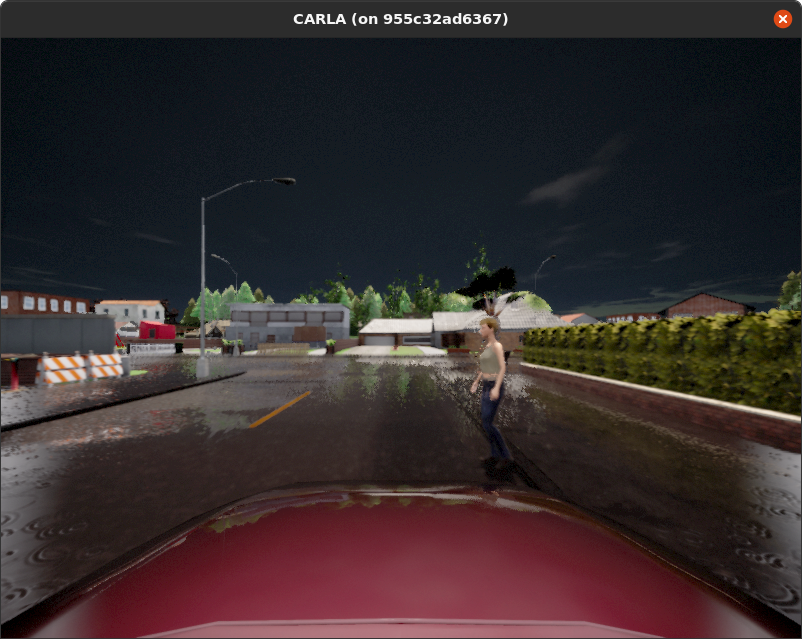

In [ ]:
We can then inspect the search results:

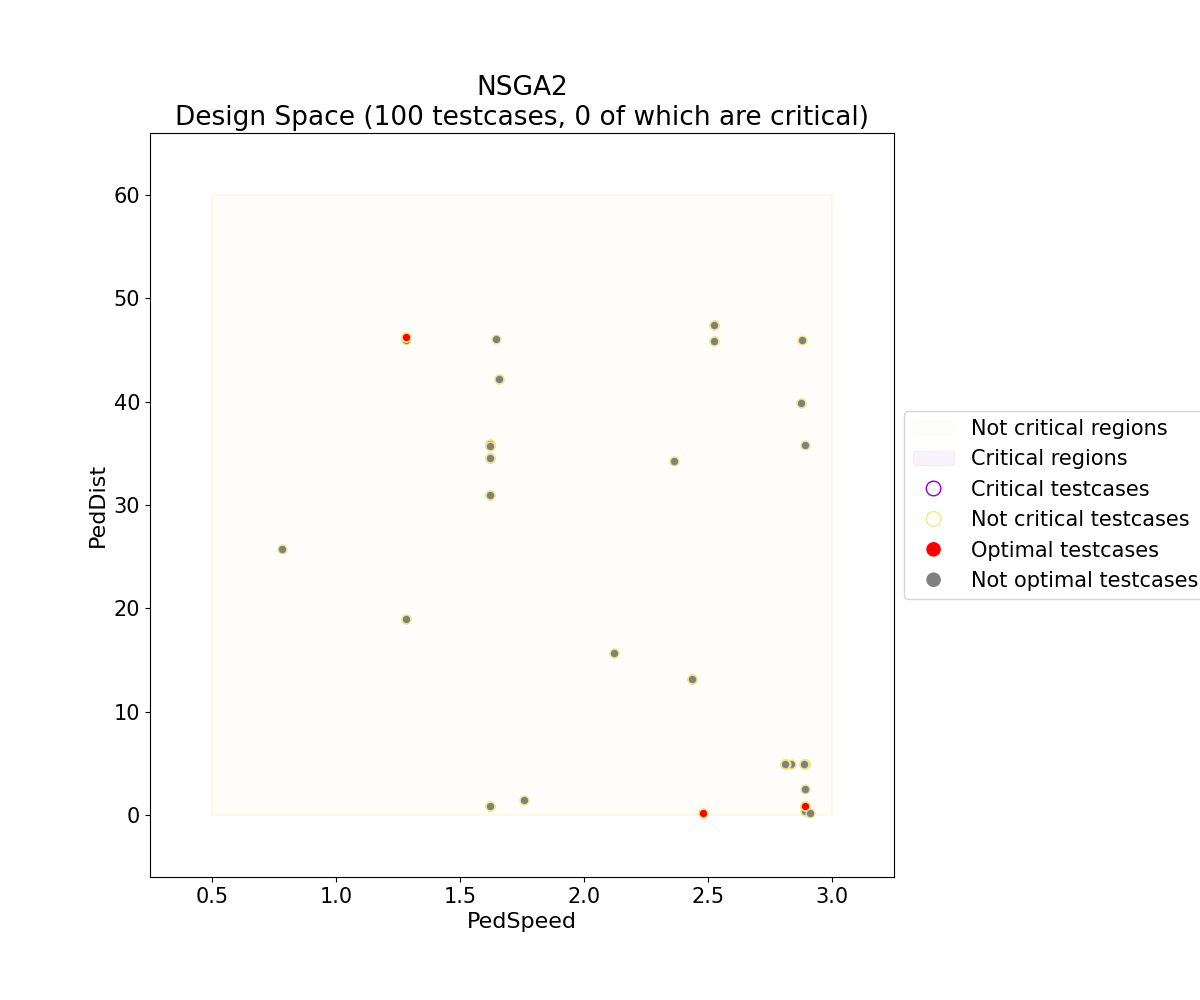

In [5]:
from os import listdir
from random import choice
from IPython.display import Image

RESULTS_DIR = "tmp/opensbt/core/results"

# As we have executed only one experiment, we can access it randomly.
by_scenario = "{}/{}".format(RESULTS_DIR, choice(listdir(RESULTS_DIR)))
by_algorithm = "{}/{}".format(by_scenario, choice(listdir(by_scenario)))
by_time = "{}/{}".format(by_algorithm, choice(listdir(by_algorithm)))

Image(filename="{}/design_space/PedSpeed_PedDist.png".format(by_time))